In [1]:
%matplotlib inline


# Multiclass sparse logisitic regression on newgroups20
# 基于newgroups20数据集的多类稀疏Ligistic回归

Comparison of multinomial logistic L1 vs one-versus-rest L1 logistic regression to classify documents from the newgroups20 dataset. Multinomial logistic regression yields more accurate results and is faster to train on the larger scale dataset.

Here we use the l1 sparsity that trims the weights of not informative features to zero. This is good if the goal is to extract the strongly
discriminative vocabulary of each class. If the goal is to get the best predictive accuracy, it is better to use the non sparsity-inducing l2 penalty instead.

A more traditional (and possibly better) way to predict on a sparse subset of input features would be to use univariate feature selection followed by a traditional (l2-penalised) logistic regression model.

基于newgroups20数据集，比较多项式与One-vs-Rest的L1惩罚的Logistic回归分类。多项式Logistic回归能够产生更精确的结果，并且在大规模数据集上训练更快。

本例使用L1稀疏度，将非信息特征值的权重设置为零。这样做的好处是在每个分类文章下，可以更精准的提取特征词，通过这些词能更加精准地对文章分类。如果要获得最好的分类预测正确率，最好使用非稀疏的L2惩罚。

对于输入特征是稀疏集的数据集进行预测，一种更为传统（可能更好）的方法是使用单变量特征选择，然后使用传统（L2惩罚）Logistic回归模型。

In [2]:
print(__doc__)
# Author: Arthur Mensch

import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Automatically created module for IPython interactive environment


In [3]:
t0 = time.process_time()

# We use SAGA solver
# 设置求解方法为saga
solver = 'saga'

# Turn down for faster run time
# 设置少量样本数，加快模型训练运行速度
n_samples = 10000

# Memorized fetch_rcv1 for faster access
# 加载全部集合，包括训练集和测试集
dataset = fetch_20newsgroups_vectorized('all')
X = dataset.data
y = dataset.target
# 取前10000条数据
X = X[:n_samples]
y = y[:n_samples]

In [4]:
# 对数据进行交叉验证，分为90%的训练集，10%的测试集
# stratify = y: 依据标签y，按原数据集y中各类比例，分配给train和test，使得train和test中各类数据的比例与原数据集一样。 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.1)
# 得到训练集的样本数和特征数
train_samples, n_features = X_train.shape
# 得到标签的分类总数（一共有多少类）
n_classes = np.unique(y).shape[0]

print('Dataset 20newsgroup, train_samples=%i, n_features=%i, n_classes=%i'
      % (train_samples, n_features, n_classes))

Dataset 20newsgroup, train_samples=9000, n_features=130107, n_classes=20


20newsgroup数据集，训练数据集有9000个样本，有130107个特征值，20个类别

In [5]:
# 设置模型参数
models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 3]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7]}}

for model in models:
    # Add initial chance-level values for plotting purpose
    # 为了绘图，设置初始参数
    accuracies = [1 / n_classes]
    times = [0]
    densities = [1]
    
    # 获得模型参数（即得到name和iters）
    model_params = models[model]

    # Small number of epochs for fast runtime
    # 用小的迭代次数进行迭代
    for this_max_iter in model_params['iters']:
        # 打印参数信息
        # print('[model=%s, solver=%s] Number of epochs: %s' % (model_params['name'], solver, this_max_iter))
        print('[模型：%s, 求解方法：%s] 迭代次数: %s' % (model_params['name'], solver, this_max_iter))
        # 设置模型参数，初始化Logistic回归模型
        lr = LogisticRegression(solver=solver,
                                multi_class=model,
                                C=1,
                                penalty='l1',
                                fit_intercept=True,
                                max_iter=this_max_iter,
                                random_state=42,
                                )
        t1 = time.process_time()
        # 训练模型
        lr.fit(X_train, y_train)
        train_time = time.process_time() - t1
        
        # 交叉验证，预测测试集的分类
        y_pred = lr.predict(X_test)
        # 得到准确率
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        # 得到非0特征系数，并求每一行的平均值
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        # 保存准确率，均值，训练时间
        accuracies.append(accuracy)
        densities.append(density)
        times.append(train_time)
    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['accuracies'] = accuracies
    # print('Test accuracy for model %s: %.4f' % (model, accuracies[-1]))
    # print('%% non-zero coefficients for model %s, per class:\n %s' % (model, densities[-1]))
    # print('Run time (%i epochs) for model %s: %.2f' % (model_params['iters'][-1], model, times[-1]))
    # 打印最后一次迭代的模型性能指标
    print('%s模型的测试准确率: %.4f' % (model, accuracies[-1]))
    print('%% %s模型的非零系数, 每个分类的系数值:\n %s' % (model, densities[-1]))
    print('%s模型迭代%i次的运行时间(s): %.2f' % (model, model_params['iters'][-1], times[-1]))

[模型：One versus Rest, 求解方法：saga] 迭代次数: 1


E:\DevSoft\Python\Python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[模型：One versus Rest, 求解方法：saga] 迭代次数: 3
ovr模型的测试准确率: 0.7410
% ovr模型的非零系数, 每个分类的系数值:
 [0.27054655 0.66330021 0.80395367 0.73247404 0.67713497 0.73477984
 0.40889422 0.48959702 1.01301237 0.56261385 0.60104376 0.332803
 0.7094161  0.85083816 0.56876263 0.65715142 0.64408525 0.81163965
 0.44271254 0.41120001]
ovr模型迭代3次的运行时间(s): 3.62
[模型：Multinomial, 求解方法：saga] 迭代次数: 1
[模型：Multinomial, 求解方法：saga] 迭代次数: 3
[模型：Multinomial, 求解方法：saga] 迭代次数: 7
multinomial模型的测试准确率: 0.7450
% multinomial模型的非零系数, 每个分类的系数值:
 [0.13296748 0.11759552 0.13296748 0.13988486 0.1268187  0.16140561
 0.15218243 0.09069458 0.07762841 0.12143851 0.14910804 0.10837234
 0.18830655 0.1245129  0.168323   0.21828188 0.11605832 0.07839701
 0.06917383 0.15602543]
multinomial模型迭代7次的运行时间(s): 4.99


本例总运行时间 14.758 s


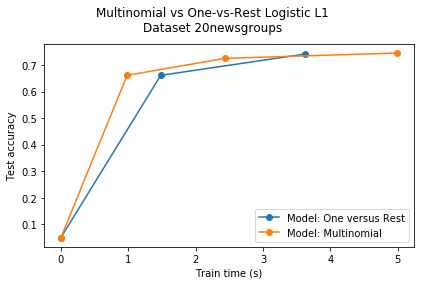

In [6]:
# 初始化plt
fig = plt.figure()
ax = fig.add_subplot(111)

# 针对两个模型分别绘制折线图
for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['accuracies']
    # 绘制折线，横坐标为运行时间，纵坐标为模型准确率
    ax.plot(times, accuracies, marker='o',
            label='Model: %s' % name)
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Test accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n'
             'Dataset %s' % '20newsgroups')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = time.process_time() - t0
# 打印总运行时间
# print('Example run in %.3f s' % run_time)
print('本例总运行时间 %.3f s' % run_time)
plt.show()